In [50]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from plotnine import ggplot, aes, geom_bar, coord_flip, labs, theme_minimal

In [51]:
hitters = pd.read_csv("Hitters.csv")
hitters = hitters.dropna()
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


## Part I: Different Model Specs

## A. Regression without regularization

In [52]:
X = hitters.drop(["Salary"], axis = 1)
y = hitters["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(drop='first', sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [53]:
lr_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bafdbb3ac80>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bafdbb3bf40>)])),
                ('linear_regression', LinearRegression())])

In [54]:
coefficients = lr_pipeline.named_steps["linear_regression"].coef_
feature_names = lr_pipeline.named_steps["preprocessing"].get_feature_names_out()
lr_coeff = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
lr_coeff = lr_coeff.reindex(lr_coeff["Coefficient"].abs().sort_values(ascending=False).index)
lr_coeff.head()

,Feature,Coefficient
13,standardize__CRuns,480.747135
10,standardize__CAtBat,-391.038655
4,standardize__Hits,337.830479
3,standardize__AtBat,-291.094556
14,standardize__CRBI,260.689886


With linear regression, **CRuns has the largest positive impact** on Salary while **CAtBat has the largest negative impact** on Salary

In [55]:
lr_mse = -cross_val_score(lr_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
lr_mse.mean()

121136.31031816883

## B. Ridge regression

In [56]:
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

since we want to predict the salary, we prioritize a smaller mse over a better r2


In [57]:
degree = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_gscv = GridSearchCV(ridge_pipeline, degree, cv=5, scoring='neg_mean_squared_error')
ridge_gscv_fitted = ridge_gscv.fit(X, y)

mean_mse = ridge_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(ridge_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df

,ridge_regression__alpha,MSE
0,0.001,121124.318914
1,0.010,121021.508944
2,0.100,120329.936014
3,1.000,119034.332720
4,10.000,119073.956166
5,100.000,121274.424070


In [58]:
ridge_1_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)
ridge_1_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bafdbb3ac80>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bafdbb3bf40>)])),
                ('ridge_regression', Ridge(alpha=1))])

In [59]:
coefficients = ridge_1_pipeline.named_steps["ridge_regression"].coef_
feature_names = ridge_1_pipeline.named_steps["preprocessing"].get_feature_names_out()
r_coeff = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
r_coeff = r_coeff.reindex(r_coeff["Coefficient"].abs().sort_values(ascending=False).index)
r_coeff.head()

,Feature,Coefficient
13,standardize__CRuns,320.802717
4,standardize__Hits,296.801967
3,standardize__AtBat,-271.088165
10,standardize__CAtBat,-225.511649
15,standardize__CWalks,-184.289408


In ridge regression using *alpha=1*, **CRuns has the largest positive impact** on Salary while **AtBat has the largest negative impact** on Salary

In [60]:
ridge_mse = -cross_val_score(ridge_1_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
ridge_mse.mean()

119034.33271954508

## C. Lasso Regression

In [61]:
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

since we want to predict the salary, we prioritize a smaller mse over a better r2

In [62]:
degree = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_gscv = GridSearchCV(lasso_pipeline, degree, cv=5, scoring='neg_mean_squared_error')
lasso_gscv_fitted = lasso_gscv.fit(X, y)

mean_mse = lasso_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(lasso_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.984e+06, tolerance: 3.606e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+07, tolerance: 4.137e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

,lasso_regression__alpha,MSE
0,0.001,120994.179815
1,0.010,120964.764686
2,0.100,120682.252637
3,1.000,119761.587407
4,10.000,121828.141333
5,100.000,143755.162381


In [63]:
lasso_1_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha=1))]
)
lasso_1_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bafdbb3ac80>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bafdbb3bf40>)])),
                ('lasso_regression', Lasso(alpha=1))])

In [64]:
coefficients = lasso_1_pipeline.named_steps["lasso_regression"].coef_
feature_names = lasso_1_pipeline.named_steps["preprocessing"].get_feature_names_out()
l_coeff = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
l_coeff = l_coeff.reindex(l_coeff["Coefficient"].abs().sort_values(ascending=False).index)
l_coeff.head()

,Feature,Coefficient
13,standardize__CRuns,375.565519
4,standardize__Hits,304.359509
3,standardize__AtBat,-282.370957
14,standardize__CRBI,192.610892
15,standardize__CWalks,-189.644642


In lasso regression using *alpha=1*, **CRuns has the largest positive impact** on Salary while **AtBat has the largest negative impact** on Salary

In [65]:
lasso_mse = -cross_val_score(lasso_1_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
lasso_mse.mean()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03


119761.58740741298

## D. Elastic Net

In [66]:
elasticnet_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elasticnet_regression", ElasticNet())]
)

since we want to predict the salary, we prioritize a smaller mse over a better r2

In [67]:
degree = {'elasticnet_regression__alpha': [0.001, 0.01, 0.1, 1, 10],
          'elasticnet_regression__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]}
elasticnet_gscv = GridSearchCV(elasticnet_pipeline, degree, cv=5, scoring='neg_mean_squared_error')
elasticnet_gscv_fitted = elasticnet_gscv.fit(X, y)

mean_mse = elasticnet_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(elasticnet_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df = df.reindex(df["MSE"].abs().sort_values(ascending=True).index)
df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.034e+07, tolerance: 4.708e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.138e+06, tolerance: 3.606e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.030e+07, tolerance: 4.137e+03
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

,elasticnet_regression__alpha,elasticnet_regression__l1_ratio,MSE
13,0.10,0.9,118794.049617
5,0.01,0.1,118802.210703
12,0.10,0.7,118841.088130
6,0.01,0.5,119009.717644
11,0.10,0.5,119116.473171


In [68]:
elasticnet_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("elasticnet_regression", ElasticNet(alpha=0.1, l1_ratio=0.9))]
)
elasticnet_pipeline_2.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bafdbb3ac80>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bafdbb3bf40>)])),
                ('elasticnet_regression', ElasticNet(alpha=0.1, l1_ratio=0.9))])

In [69]:
coefficients = elasticnet_pipeline_2.named_steps["elasticnet_regression"].coef_
feature_names = elasticnet_pipeline_2.named_steps["preprocessing"].get_feature_names_out()
e_coeff = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
e_coeff = e_coeff.reindex(e_coeff["Coefficient"].abs().sort_values(ascending=False).index)
e_coeff.head()

,Feature,Coefficient
4,standardize__Hits,247.796604
3,standardize__AtBat,-232.313926
13,standardize__CRuns,223.613974
15,standardize__CWalks,-154.323946
14,standardize__CRBI,121.573427


In elastic net using *alpha=0.1 and l1_ratio=0.9*, **Hits has the largest positive impact** on Salary while **AtBat has the largest negative impact** on Salary

In [70]:
elasticnet_mse = -cross_val_score(elasticnet_pipeline_2, X, y, cv = 5, scoring = 'neg_mean_squared_error')
elasticnet_mse.mean()

118794.04961667531

## Part II. Variable Selection

### - Which numeric variable is most important?
Based on the coefficients computed using above methods, we conclude that **CRuns is the most important numeric variable**, as it has the largest or second largest absolute coefficients using different approach

### - Which five numeric variables are most important?
Based on the coefficients computed above, **CRuns, Hits, AtBat** are the top three most important numeric variables since they all have big absolute coefficient in every approch used above. Follow by **CWalks and CRBI** because they have the largest absolute coefficient in Elastic Net where the MSE is the smallest

### - Which categorical variable is most important?
Based on the coefficients computed below, **Division is the most important categorical variable**

In [71]:
lr_cat_coef = lr_coeff[lr_coeff['Feature'].str.contains('dummify__')]
lr_cat_coef = lr_cat_coef.reindex(lr_cat_coef["Coefficient"].abs().sort_values(ascending=False).index)
lr_cat_coef.head()


,Feature,Coefficient
1,dummify__Division_W,-116.849246
0,dummify__League_N,62.599423
2,dummify__NewLeague_N,-24.762325


In [72]:
r_cat_coef = r_coeff[r_coeff['Feature'].str.contains('dummify__')]
r_cat_coef = r_cat_coef.reindex(r_cat_coef["Coefficient"].abs().sort_values(ascending=False).index)
r_cat_coef.head()

,Feature,Coefficient
1,dummify__Division_W,-119.076927
0,dummify__League_N,58.555947
2,dummify__NewLeague_N,-24.027205


In [73]:
l_cat_coef = l_coeff[l_coeff['Feature'].str.contains('dummify__')]
l_cat_coef = l_cat_coef.reindex(l_cat_coef["Coefficient"].abs().sort_values(ascending=False).index)
l_cat_coef.head()

,Feature,Coefficient
1,dummify__Division_W,-114.412951
0,dummify__League_N,35.826072
2,dummify__NewLeague_N,-0.000000


In [74]:
e_cat_coef = e_coeff[e_coeff['Feature'].str.contains('dummify__')]
e_cat_coef = e_cat_coef.reindex(e_cat_coef["Coefficient"].abs().sort_values(ascending=False).index)
e_cat_coef.head()

,Feature,Coefficient
1,dummify__Division_W,-118.890401
0,dummify__League_N,51.052075
2,dummify__NewLeague_N,-17.997435


### Using only the one best numeric variable.



In [75]:
X_best_numeric = hitters[["CRuns"]]
y = hitters["Salary"]
# linear
lr_pipeline.fit(X_best_numeric, y)
lr_mse = -cross_val_score(lr_pipeline, X_best_numeric, y, cv = 5, scoring = 'neg_mean_squared_error')
lr_mse.mean()

143812.9359162973

In [76]:
# ridge
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)
# tune
degree = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_gscv = GridSearchCV(ridge_pipeline, degree, cv=5, scoring='neg_mean_squared_error')
ridge_gscv_fitted = ridge_gscv.fit(X_best_numeric, y)

mean_mse = ridge_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(ridge_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df

,ridge_regression__alpha,MSE
0,0.001,143812.905015
1,0.010,143812.627051
2,0.100,143809.862456
3,1.000,143783.706854
4,10.000,143658.517369
5,100.000,148807.783475


In [77]:
ridge_10_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=10))]
)
ridge_10_pipeline.fit(X_best_numeric, y)

r_mse = -cross_val_score(ridge_10_pipeline, X_best_numeric, y, cv = 5, scoring = 'neg_mean_squared_error')
r_mse.mean()

143658.5173685888

In [78]:
# lasso
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)
# tune
degree = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_gscv = GridSearchCV(lasso_pipeline, degree, cv=5, scoring='neg_mean_squared_error')
lasso_gscv_fitted = lasso_gscv.fit(X_best_numeric, y)

mean_mse = lasso_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(lasso_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df

,lasso_regression__alpha,MSE
0,0.001,143812.923545
1,0.010,143812.812299
2,0.100,143811.709122
3,1.000,143801.606084
4,10.000,143793.449159
5,100.000,152999.224797


In [79]:
lasso_10_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha=10))]
)

lasso_10_pipeline.fit(X_best_numeric, y)

l_mse = -cross_val_score(lasso_10_pipeline, X_best_numeric, y, cv = 5, scoring = 'neg_mean_squared_error')
l_mse.mean()

143793.4491585397

In [80]:
# elastic net
elasticnet_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elasticnet_regression", ElasticNet())]
)
# tune
degree = {'elasticnet_regression__alpha': [0.001, 0.01, 0.1, 1, 10],
          'elasticnet_regression__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]}
elasticnet_gscv = GridSearchCV(elasticnet_pipeline, degree, cv=5, scoring='neg_mean_squared_error')
elasticnet_gscv_fitted = elasticnet_gscv.fit(X_best_numeric, y)

mean_mse = elasticnet_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(elasticnet_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df = df.reindex(df["MSE"].abs().sort_values(ascending=True).index)
df.head()

,elasticnet_regression__alpha,elasticnet_regression__l1_ratio,MSE
11,0.10,0.5,143655.076048
12,0.10,0.7,143679.366378
10,0.10,0.1,143735.873327
13,0.10,0.9,143753.808898
5,0.01,0.1,143759.624708


In [81]:
elasticnet_pipeline_3 = Pipeline(
  [("preprocessing", ct),
  ("elasticnet_regression", ElasticNet(alpha=0.1, l1_ratio=0.5))]
)
elasticnet_pipeline_3.fit(X_best_numeric, y)

e_mse = -cross_val_score(elasticnet_pipeline_3, X_best_numeric, y, cv = 5, scoring = 'neg_mean_squared_error')
e_mse.mean()

143655.07604766646

### Conclusion: **Elastic Net performs the best when using only the best numeric variable**

### Using only the five best variables

In [82]:
X_5 = hitters[["CRuns", "Hits", "AtBat", "CWalks", "CRBI"]]
y = hitters["Salary"]
# linear
lr_pipeline.fit(X_5, y)
lr_mse = -cross_val_score(lr_pipeline, X_5, y, cv = 5, scoring = 'neg_mean_squared_error')
lr_mse.mean()

125502.85287637594

In [83]:
# ridge
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)
# tune
degree = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_gscv = GridSearchCV(ridge_pipeline, degree, cv=5, scoring='neg_mean_squared_error')
ridge_gscv_fitted = ridge_gscv.fit(X_5, y)

mean_mse = ridge_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(ridge_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df

,ridge_regression__alpha,MSE
0,0.001,125502.330042
1,0.010,125497.642843
2,0.100,125452.540281
3,1.000,125142.787641
4,10.000,125412.154870
5,100.000,127905.951040


In [84]:
r1_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)
r1_pipeline.fit(X_5, y)

r_mse = -cross_val_score(r1_pipeline, X_5, y, cv = 5, scoring = 'neg_mean_squared_error')
r_mse.mean()

125142.78764099171

In [85]:
# lasso
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)
# tune
degree = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_gscv = GridSearchCV(lasso_pipeline, degree, cv=5, scoring='neg_mean_squared_error')
lasso_gscv_fitted = lasso_gscv.fit(X_5, y)

mean_mse = lasso_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(lasso_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df

,lasso_regression__alpha,MSE
0,0.001,125502.224198
1,0.010,125496.578699
2,0.100,125441.209076
3,1.000,125290.491070
4,10.000,127516.270061
5,100.000,144291.486081


In [86]:
l1_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha=1))]
)

l1_pipeline.fit(X_5, y)

l_mse = -cross_val_score(l1_pipeline, X_5, y, cv = 5, scoring = 'neg_mean_squared_error')
l_mse.mean()

125290.4910700492

In [87]:
# elastic net
elasticnet_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elasticnet_regression", ElasticNet())]
)
# tune
degree = {'elasticnet_regression__alpha': [0.001, 0.01, 0.1, 1, 10],
          'elasticnet_regression__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]}
elasticnet_gscv = GridSearchCV(elasticnet_pipeline, degree, cv=5, scoring='neg_mean_squared_error')
elasticnet_gscv_fitted = elasticnet_gscv.fit(X_5, y)

mean_mse = elasticnet_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(elasticnet_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df = df.reindex(df["MSE"].abs().sort_values(ascending=True).index)
df.head()

,elasticnet_regression__alpha,elasticnet_regression__l1_ratio,MSE
13,0.10,0.9,124989.325794
5,0.01,0.1,125002.546444
6,0.01,0.5,125129.776119
12,0.10,0.7,125132.910248
7,0.01,0.7,125241.423825


In [88]:
elasticnet_pipeline_4 = Pipeline(
  [("preprocessing", ct),
  ("elasticnet_regression", ElasticNet(alpha=0.1, l1_ratio=0.9))]
)
elasticnet_pipeline_4.fit(X_5, y)

e_mse = -cross_val_score(elasticnet_pipeline_4, X_5, y, cv = 5, scoring = 'neg_mean_squared_error')
e_mse.mean()

124989.32579359246

### Conclusion: **Elastic Net performs the best when using only the best five variables**

### Using the five best numeric variables and their interactions with the one best categorical variable

In [89]:
X = hitters.drop(["Salary"], axis = 1)
y = hitters["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(drop='first', sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

ct2 = ColumnTransformer([
    ("interaction1", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction2", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction3", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__AtBat", "dummify__Division_W"]),
    ("interaction4", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__CWalks", "dummify__Division_W"]),
    ("interaction5", PolynomialFeatures(interaction_only=True, include_bias=False), ["standardize__CRBI", "dummify__Division_W"])
], remainder = "drop").set_output(transform="pandas")

ct_keep = ColumnTransformer(
    [
      ("keep", FunctionTransformer(), ['interaction1__standardize__CRuns',
       'interaction1__standardize__CRuns dummify__Division_W',
       'interaction2__standardize__Hits', 'interaction2__standardize__Hits dummify__Division_W',
       'interaction3__standardize__AtBat', 'interaction3__standardize__AtBat dummify__Division_W',
       'interaction4__standardize__CWalks', 'interaction4__standardize__CWalks dummify__Division_W',
       'interaction5__standardize__CRBI', 'interaction5__standardize__CRBI dummify__Division_W'])
  ],
  remainder = "drop"
).set_output(transform="pandas")

lr_pipeline_new = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct2),
   ("keep", ct_keep),
   ("linear_regression", LinearRegression())]
)

In [90]:
lr_pipeline_new.fit(X, y)
lr_mse = -cross_val_score(lr_pipeline_new, X, y, cv = 5, scoring = 'neg_mean_squared_error')
lr_mse.mean()

136501.2348892411

In [91]:
# ridge
ridge_pipeline_new = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct2),
   ("keep", ct_keep),
   ("ridge_regression", Ridge())]
)
# tune
degree = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_gscv = GridSearchCV(ridge_pipeline_new, degree, cv=5, scoring='neg_mean_squared_error')
ridge_gscv_fitted = ridge_gscv.fit(X, y)

mean_mse = ridge_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(ridge_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df

,ridge_regression__alpha,MSE
0,0.001,136491.720609
1,0.010,136406.997605
2,0.100,135640.833734
3,1.000,131861.725477
4,10.000,127156.677811
5,100.000,128145.939162


In [92]:
r10_pipeline = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct2),
   ("keep", ct_keep),
   ("ridge_regression", Ridge(alpha=10))]
)
r10_pipeline.fit(X, y)

r10_mse = -cross_val_score(r10_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
r10_mse.mean()

127156.6778106635

In [93]:
# lasso
lasso_pipeline_new = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct2),
   ("keep", ct_keep),
   ("lasso_regression", Lasso())]
)
# tune
degree = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_gscv = GridSearchCV(lasso_pipeline_new, degree, cv=5, scoring='neg_mean_squared_error')
lasso_gscv_fitted = lasso_gscv.fit(X, y)

mean_mse = lasso_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(lasso_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df

,lasso_regression__alpha,MSE
0,0.001,136498.206762
1,0.010,136470.248497
2,0.100,136199.486567
3,1.000,133676.370784
4,10.000,128263.382635
5,100.000,144291.486081


In [94]:
l10_pipeline = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct2),
   ("keep", ct_keep),
   ("lasso_regression", Lasso(alpha=10))]
)
l10_pipeline.fit(X, y)

l10_mse = -cross_val_score(l10_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
l10_mse.mean()

128263.38263533238

In [95]:
# elastic net
elasticnet_pipeline_new = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct2),
   ("keep", ct_keep),
   ("elasticnet_regression", ElasticNet())]
)
# tune
degree = {'elasticnet_regression__alpha': [0.001, 0.01, 0.1, 1, 10],
          'elasticnet_regression__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]}
elasticnet_gscv = GridSearchCV(elasticnet_pipeline_new, degree, cv=5, scoring='neg_mean_squared_error')
elasticnet_gscv_fitted = elasticnet_gscv.fit(X, y)

mean_mse = elasticnet_gscv_fitted.cv_results_['mean_test_score']
df = pd.DataFrame(elasticnet_gscv_fitted.cv_results_['params'])
df['MSE'] = -mean_mse
df = df.reindex(df["MSE"].abs().sort_values(ascending=True).index)
df.head()

,elasticnet_regression__alpha,elasticnet_regression__l1_ratio,MSE
18,1.0,0.9,126285.269253
10,0.1,0.1,126529.262679
17,1.0,0.7,126930.792929
11,0.1,0.5,127078.720215
12,0.1,0.7,127841.303724


In [96]:
e_pipeline = Pipeline(
  [("preprocessing", ct),
   ("interaction", ct2),
   ("keep", ct_keep),
   ("elasticnet_regression", ElasticNet(alpha=1, l1_ratio=0.9))]
)
e_pipeline.fit(X, y)

e_mse = -cross_val_score(e_pipeline, X, y, cv = 5, scoring = 'neg_mean_squared_error')
e_mse.mean()

126285.26925281396

### Conclusion: **Elastic Net performs the best when using the five best variables**

## Part III. Discussion

## A. Ridge
We can see from Part1 that Ridge model has a smaller coefficients compare to ordinary regression model. This is because ridge regression adds on a penalty to the squared error. The regularization term
discourages large coefficient values by adding alpha for their magnitude. As alpha increases, the model penalizes large coefficients more, effectively shrinking them toward zero.

## B. Lasso
## - Dfferent Alpha
I got alpha=10 when using only the best numeric variable, and using the five best numeric variables and their interactions with the one best categorical variable. And I got alpha=1 when including all the variables and only using 5 best variables.

This makes sense because the optimal α depends on the complexity of a model. A simpler model with fewer features(eg. only the best variable) would have a higher α to penalize large coefficients and avoid overfitting, while a more complex model with all variables requires a lower α to prevent underfitting and to allow the model to capture more relationships

Moreover, because of lasso's selection feature, it would pushes the irrelevant predictors' coefficientss to zero, therefore, even though five best numeric variables and their interactions with the one best categorical variable is a more complex model, perhaps the interaction variable is less relevant, a higher α could then zero out the interaction terms and simplify the model, resulting in better performance.

## - Different MSE
I got the smallest mse when using all the predictor variables and the largest mse when using the only one best numeric variable

The smallest MSE occured when using all predictor variables because this model could leverage the full dataset's information, allowing it to capture more relationships and minimize prediction error. In contrast, using only one variable left the model with high bias and insufficient flexibility, resulting in the largest MSE.



## C. Elastic Net

Elastic Net models performs better(with smallest MSE) in all different scenerios above.
This makes sense because Elastic Net it combines the benefits of Lasso's feature selection and Ridge's ability to handle multicollinearity. This combination allows Elastic Net to have more flexibly, leading to a model that can retain the most relevant information while discarding the irrelevants.

## Part IV: Final Model

In [97]:
X = hitters.drop(["Salary"], axis = 1)
y = hitters["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(drop='first', sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

elasticnet_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("elasticnet_regression", ElasticNet(alpha=0.1, l1_ratio=0.9))]
)
elasticnet_pipeline_2.fit(X, y)

elasticnet_mse = -cross_val_score(elasticnet_pipeline_2, X, y, cv = 5, scoring = 'neg_mean_squared_error')
elasticnet_mse.mean()

118794.04961667531

This Elastic Net model using every predictor variables with a alpha of 0.1 and a l1_ratio of 0.9 performs the best with the smallest MSE out of all the other models.

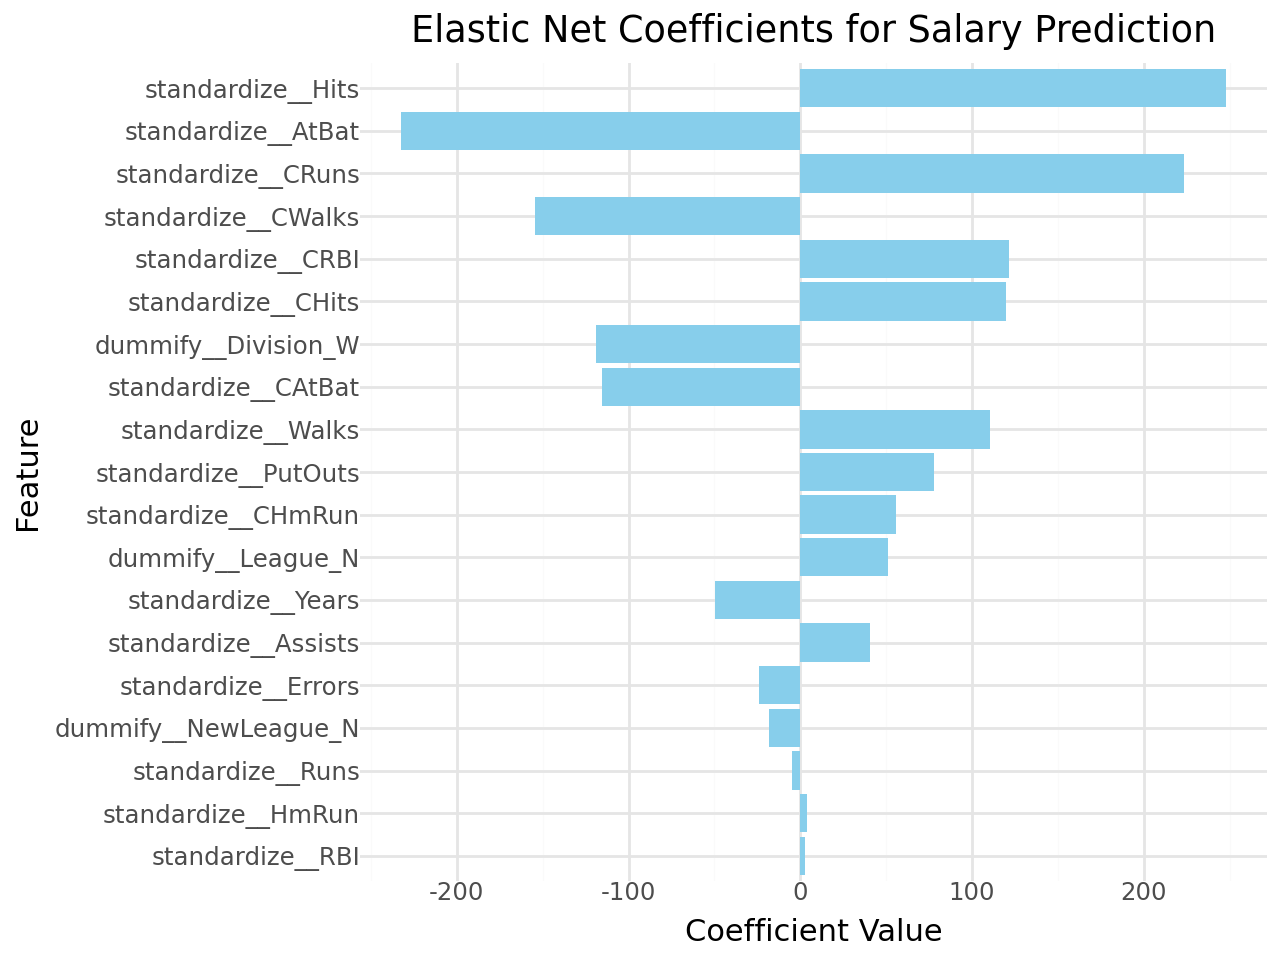

In [98]:
coefficients = elasticnet_pipeline_2.named_steps["elasticnet_regression"].coef_
feature_names = elasticnet_pipeline_2.named_steps["preprocessing"].get_feature_names_out()
e_coeff = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
e_coeff = e_coeff.reindex(e_coeff["Coefficient"].abs().sort_values(ascending=False).index)

# Selecting only non-zero coefficients
e_coeff_nonzero = e_coeff[e_coeff["Coefficient"] != 0]
(ggplot(e_coeff_nonzero, aes(x='reorder(Feature, abs(Coefficient))', y='Coefficient')) +
 geom_bar(stat='identity', fill='skyblue') +
 coord_flip() +
 labs(title='Elastic Net Coefficients for Salary Prediction',
      x='Feature',
      y='Coefficient Value') +
 theme_minimal()
 )
